In [1]:
%matplotlib inline

#### (import x 4; from scalygraphic repo)
### prototype 
    edge-image abstraction with non-linear difference equation as basis for nmf to encoding kernal identifier
    
#### Future Exploration: encodable ?
    qualia recognition basis equations - ? graphical qualities recognized be human vision encodable?
    


In [2]:
import time
all_cells_start_time = time.time()

"""
                    ( required for first time tensorflow.keras.datasets -- mnist.load_data() )
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

"""
import numpy as np
import numpy.linalg as LA

import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

import os
import sys

scalygraphic_clone_dir = '../../scalygraphic/src/'

if os.path.isdir(scalygraphic_clone_dir) == True:
    sys.path.insert(0, scalygraphic_clone_dir)
else:
    print('dir not found')
    
from impute_color import *
from im_scale_products import *
import eq_iter
import zplain

In [3]:
def get_test_domain_dict(it_max=None, scale_dist=None):
    """ Usage: 
    domain_dict = get_center_domain_dict(it_max, scale_dist)
    """
    if it_max is None:
        it_max = 64
        
    if scale_dist is None:
        scale_dist = 12
        
    domain_dict = get_default_domain_dict()
    domain_dict['it_max'] = it_max
    domain_dict['max_d'] = scale_dist / domain_dict['zoom']
    domain_dict['n_rows'] = 255
    domain_dict['n_cols'] = 255
    
    return domain_dict

#                             for this notebook
def view_equation_options():
    print('\n\t\t\tEquations enumeration of (Name, function_handle) tuples')
    for k, v in NAMED_FUNCTION_HANDLES_DICT.items():
        print(k, v)

def create_results_dir(results_dir=None):
    if results_dir is None or os.path.isdir(results_dir) == False:
        results_dir = '../../run_dir/results'
        
    if os.path.isdir(results_dir) == False:
        os.makedirs(results_dir)
        print('Made New Directory:',results_dir)
        
    return os.path.abspath(results_dir)


#                             module to be
def gray_to_complex_vector_edges(im_array, edge_n=1):
    """ Usage: complex_vector_edges = gray_to_complex_vector_edges(im_gray_array, n)
            directional-difference accross each pixel as a complex vector
    Args:
        im_gray_array:  grayscale image as an array
        n_pixels_diff:  how many pixels to differ accross - default = 1
                        
    Returns:
        vector_edges:   matrix
    """
    n = edge_n
    vector_edges = np.array(im_array.shape).astype(np.complex128)
    
    r_minus_45 = np.exp(1.0j * (-1.0)*np.pi/4)
    r_minus_90 = np.exp(1.0j * (-1.0)*np.pi/2)
    r_minus_135 = np.exp(1.0j * (-3)*np.pi/4)
    
    # Differences in the Left to Right direction
    vector_edges = ((im_array[:, n:] - im_array[:, :-n])[n:, :]).astype(np.complex128)
    # Differences in the top to bottom direction
    vector_edges += ((im_array[n:, :] - im_array[:-n, :])[:, n:]).astype(np.complex128) * r_minus_90
    # Differences in the Upper Left to Lower Right direction
    vector_edges += (im_array[:-n, :-n] - im_array[n:, n:]).astype(np.complex128) * r_minus_45
    # Differences in the Upper Right to Lower Left direction
    vector_edges += (im_array[n:, :-n] - im_array[:-n, n:]).astype(np.complex128) * r_minus_135
        
    return vector_edges


def get_Z_edges_array(sm_im, outer_dim, edge_n=1):
    """ Usage:  Z_arr = get_Z_edges_array(sm_im, outer_dim, edge_n=1)
                get the edges of an image as an array of complex vectors
    Args:
        sm_im:          an image
        outer_dim:      image outer diminsion -- could be any number
        edge_n:         edge width in matels default = 1
        
    Returns:
        Z_arr:          array of complex vectors (edge orthogonals)
        
    """
    Z = gray_to_complex_vector_edges(sm_im, edge_n)
    outer_dim = Z.shape[0]

    #                                           M_z Magnitude of Z
    M_z = Z[np.abs(Z) > 0].reshape(-1)

    #                                           M_z_idx index the sort order of the magnitudes
    M_z_idx = np.argsort(np.abs(M_z))

    #                                           Maybe Trim to size of Outer diminsion
    if len(M_z_idx) >= outer_dim:
        M_z_sorted = M_z[M_z_idx][0:outer_dim]
    else:
        M_z_sorted = M_z[M_z_idx]

    #                                           Normalize magnitude to Unit Circle
    z_dvsr = np.abs(M_z_sorted).max() / 2
    M_z_sorted = M_z_sorted / z_dvsr
    
    #                                           Restore the original order of the vectors
    Z_arr = np.zeros(outer_dim).astype(np.complex128)
    Z_arr[np.argsort(M_z_idx[0:outer_dim])] = M_z_sorted
    
    if Z_arr.shape[0] < outer_dim:
        zro_arr = np.zeros(outer_dim - Z_arr.shape[0]).astype(type(Z_arr))
        Z_arr = np.concatenate([Z_arr, np.zeros(), zro_arr])

    return Z_arr


def get_encoding_for_basis(B):
    """ Usage:  encoding_matrix = get_encoding_for_basis(basis_matrix)
                complex input and output
                Inner dimision must be small -- else very slow
                
    Args:
        B:      complex vectors matrix with small second diminsion 
                2 - 7 good > 12 badder the bigger
                input B m x inner_diminsion 
                    B*C = I; 
                    B.T*B*C = B.T*I; 
                    C = (B.T*B)^(-1)*B.T*I
                
    Returns:
        C:      complex vectors matrix with small first diminsion 
                output C inner_diminsion x m
                
    Note that B*C produces the identity matrix
                
    """
    return np.dot(LA.pinv(np.dot(B.T, B)), B.T)

def get_Z_edges_matrix(sm_im, outer_dim, inner_dim, edge_n=2):
    """ Usage:  Z_arr = get_Z_edges_array(sm_im, outer_dim, edge_n=1)
                get the edges of an image as an array of complex vectors
    Args:
        sm_im:          an image
        outer_dim:      image outer diminsion -- could be any number
        edge_n:         edge width in matels default = 1
        
    Returns:
        Z_arr:          array of complex vectors (edge orthogonals)
        
    """
    Z = gray_to_complex_vector_edges(sm_im, edge_n)
    outer_dim = Z.shape[0]

    loa_mat = np.zeros((outer_dim, inner_dim)).astype(np.complex128)
    
    mag_mat = np.abs(Z)

    row_keep_list = []
    for row in range(loa_mat.shape[0]):
        for col in range(loa_mat.shape[1]):
            row_max = mag_mat[row].argmax()
            if row_max > 0:
                loa_mat[row, col] = Z[row, row_max]
                mag_mat[row, row_max] = 0
                if not row in row_keep_list:
                    row_keep_list.append(row)

    return loa_mat[row_keep_list, :]

def complex_mat_to_int_mat(Z, pixel_type=np.uint8):
    """ Usage: mag_mat, rot_mat = complex_mat_to_int_mat(Z, pixel_type=np.uint8)
    """
    if isinstance(pixel_type, np.uint8) or isinstance(pixel_type, np.uint16):
        scaler = np.iinfo(pixel_type).max
    else:
        pixel_type = np.uint8
        scaler = np.iinfo(pixel_type).max

    mag_mat = np.abs(Z)
    rot_mat = np.arctan2(np.real(Z), np.imag(Z))

    return mag_mat, rot_mat
    

print('tensorflow version:', tf.__version__)


tensorflow version: 2.4.1


## mnist dataset from tensorflow.keras

In [4]:
print('\t\tmnist dataset from tensorflow.keras')
print('\t\tNo Random Seed: images of numbers differ with each run')

# load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('\ntype(x_train)\t\t', type(x_train), 
      '\ntype(x_train[0])\t', type(x_train[0]), 
      '\ntype(x_train[0][0,0])\t', type(x_train[0][0,0]))

# count the number of unique train labels
unique, counts = np.unique(y_train, return_counts=True)
print('\n_____ ______:\t {digit: number of images, ...}')
print("Train labels:\t", dict( zip(unique, counts) ) )

# count the number of unique test labels
unique, counts = np.unique(y_test, return_counts=True)
print("Test labels:\t", dict(zip(unique, counts)))

"""
                    Define the run_parameters (rudo_pars) for nlc iteration
                    Show the equation options
                    
"""
im_0 = x_train[0]
inner_dim = 3
    
print('\n\t\t\tRun Parameters, Domain Parameters rudo_pars')
results_dir = create_results_dir()
rudo_pars = get_default_run_parameters(results_dir)
rudo_pars['n_rows'] = im_0.shape[1]
rudo_pars['n_cols'] = inner_dim

for k, v in rudo_pars.items():
    print(k,v)
    
view_equation_options()
run_to_here_time = time.time() - all_cells_start_time
print('\n\t\ttime to this cell: %0.3f \n'%(run_to_here_time))

		mnist dataset from tensorflow.keras
		No Random Seed: images of numbers differ with each run

type(x_train)		 <class 'numpy.ndarray'> 
type(x_train[0])	 <class 'numpy.ndarray'> 
type(x_train[0][0,0])	 <class 'numpy.uint8'>

_____ ______:	 {digit: number of images, ...}
Train labels:	 {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
Test labels:	 {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}

			Run Parameters, Domain Parameters rudo_pars
dir_path /Users/daniellanier/git_clone/dlanier/run_dir/results
center_point 0j
zoom 0.5
theta 0.0
it_max 64
scale_dist 12
max_d 24.0
n_rows 28
n_cols 3

			Equations enumeration of (Name, function_handle) tuples
ElGato <function ElGato at 0x14f82f280>
IslaLace <function IslaLace at 0x14f82f040>
ItchicuPpwrF <function ItchicuPpwrF at 0x14f82f160>
Nautuliz <function Nautuliz at 0x14f829d30>
RoyalZ <function RoyalZ at 0x14f82f0d0>
bugga_bear <function bugga_bear at 0x14f82

## Utimately:

In [5]:
"""
            Null Hypothesis: This is not a good abstraction of the mnist data set
            
            Test the viability of this method of abstraction:
            Similar things create similar abstractions
            different things differ more in the abstraction
"""
print('Null Hypothesis: This is not a good abstraction of the mnist data set')
print('\n\tNext scection shows complex edges stage only\n')

Null Hypothesis: This is not a good abstraction of the mnist data set

	Next scection shows complex edges stage only




		Keras mnist images random selection:


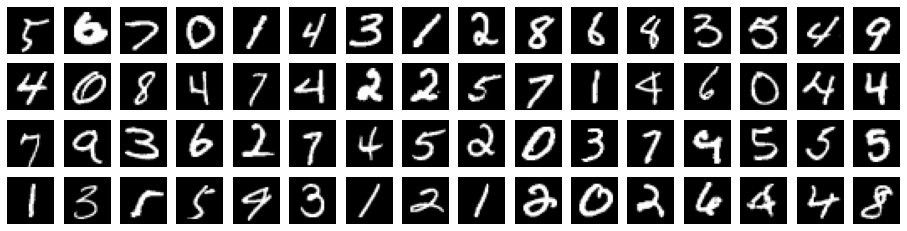

truth table:
 [[5. 6. 7. 0. 1. 4. 3. 1. 2. 8. 6. 8. 3. 5. 4. 9.]
 [4. 0. 8. 4. 7. 4. 2. 2. 5. 7. 1. 4. 6. 0. 4. 4.]
 [7. 9. 3. 6. 2. 7. 4. 5. 2. 0. 3. 7. 9. 5. 5. 5.]
 [1. 3. 5. 5. 9. 3. 1. 2. 1. 2. 0. 2. 6. 4. 4. 8.]]


		Complex edges with varied inner_dim and edge detection width edge_n

Complex edges Magnitude: 	inner_dim = 3 	edge_n = 1


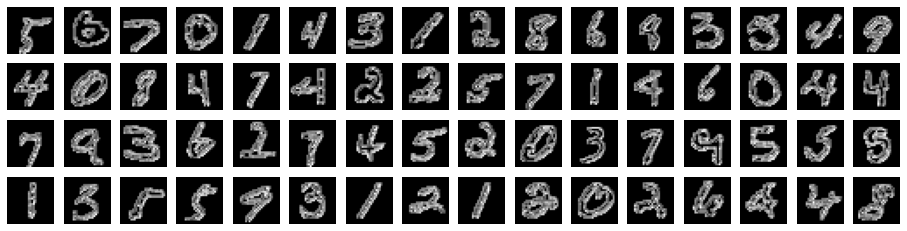

Complex edges Rotation: 	inner_dim = 3 	edge_n = 1


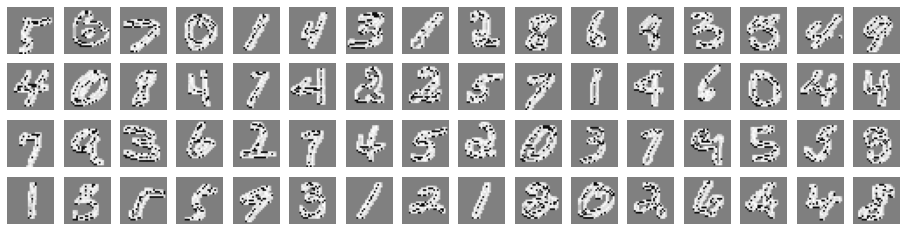

Magnitude: B*C of Factorization (BC=I) 	inner_dim = 3 	edge_n = 1


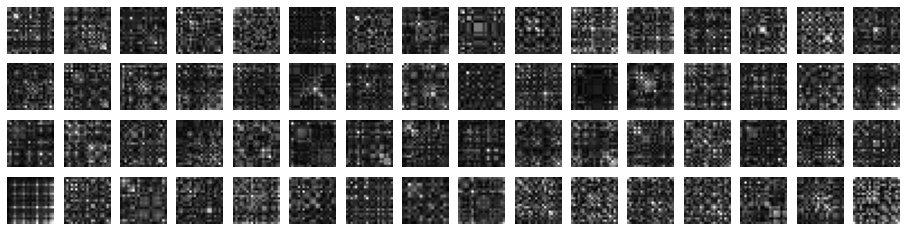

Rotation: B*C of Factorization (BC=I) 	inner_dim = 3 	edge_n = 1


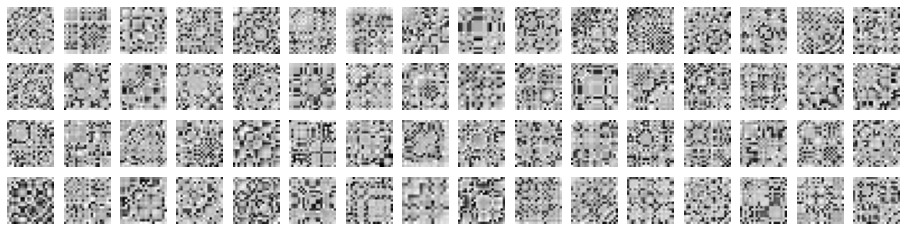

truth table:
 [[5. 6. 7. 0. 1. 4. 3. 1. 2. 8. 6. 8. 3. 5. 4. 9.]
 [4. 0. 8. 4. 7. 4. 2. 2. 5. 7. 1. 4. 6. 0. 4. 4.]
 [7. 9. 3. 6. 2. 7. 4. 5. 2. 0. 3. 7. 9. 5. 5. 5.]
 [1. 3. 5. 5. 9. 3. 1. 2. 1. 2. 0. 2. 6. 4. 4. 8.]]

			2.58 seconds


Complex edges Magnitude: 	inner_dim = 4 	edge_n = 1


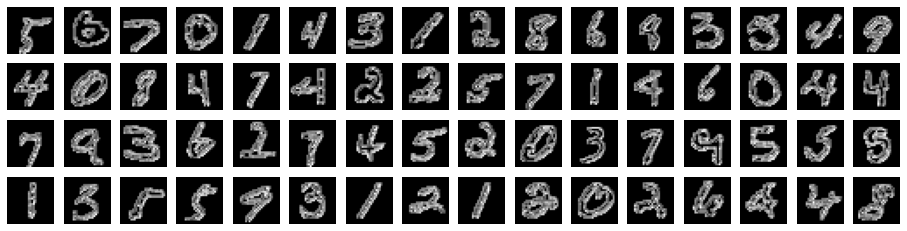

Complex edges Rotation: 	inner_dim = 4 	edge_n = 1


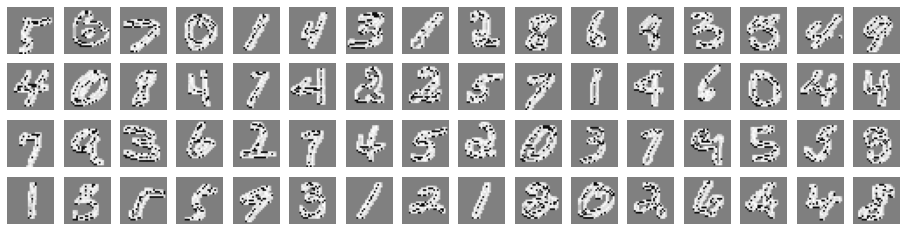

Magnitude: B*C of Factorization (BC=I) 	inner_dim = 4 	edge_n = 1


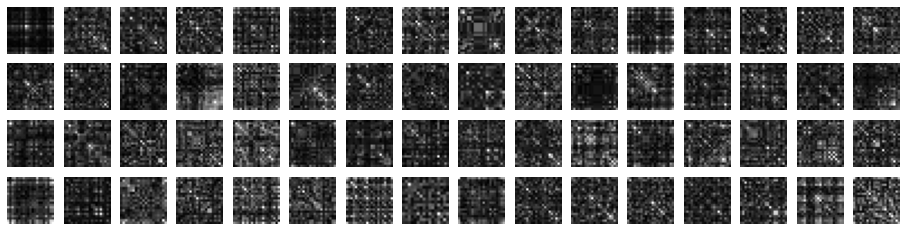

Rotation: B*C of Factorization (BC=I) 	inner_dim = 4 	edge_n = 1


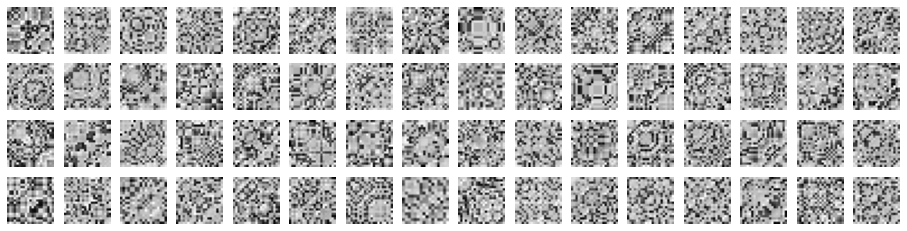

truth table:
 [[5. 6. 7. 0. 1. 4. 3. 1. 2. 8. 6. 8. 3. 5. 4. 9.]
 [4. 0. 8. 4. 7. 4. 2. 2. 5. 7. 1. 4. 6. 0. 4. 4.]
 [7. 9. 3. 6. 2. 7. 4. 5. 2. 0. 3. 7. 9. 5. 5. 5.]
 [1. 3. 5. 5. 9. 3. 1. 2. 1. 2. 0. 2. 6. 4. 4. 8.]]

			2.62 seconds


Complex edges Magnitude: 	inner_dim = 5 	edge_n = 1


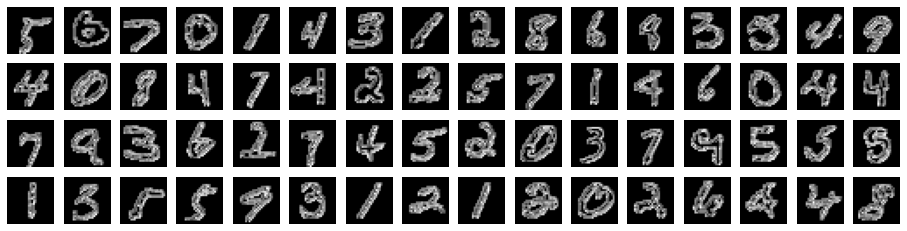

Complex edges Rotation: 	inner_dim = 5 	edge_n = 1


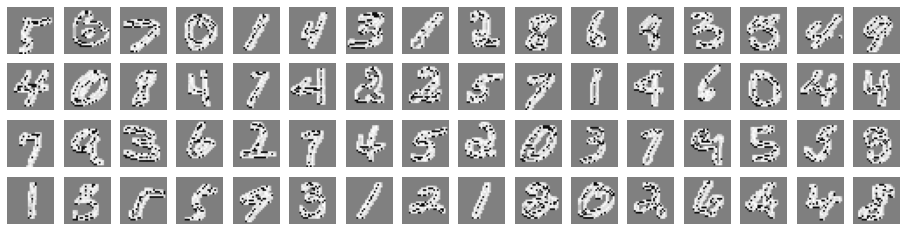

Magnitude: B*C of Factorization (BC=I) 	inner_dim = 5 	edge_n = 1


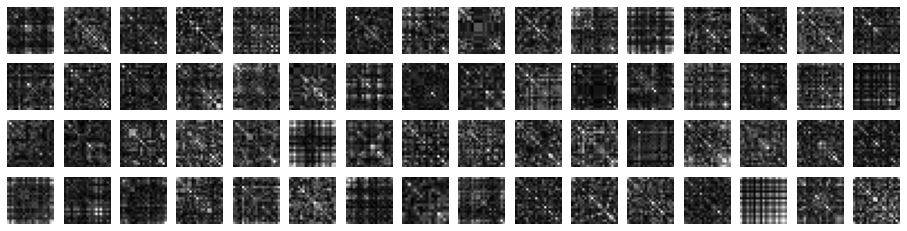

Rotation: B*C of Factorization (BC=I) 	inner_dim = 5 	edge_n = 1


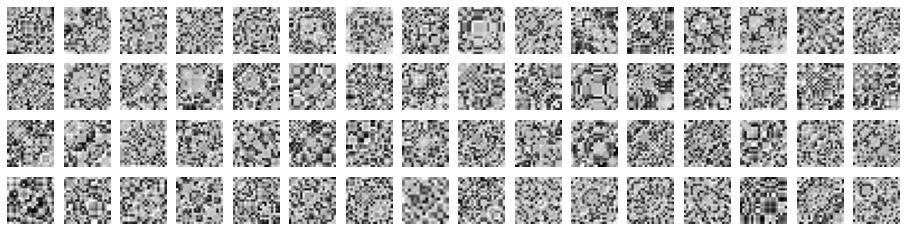

truth table:
 [[5. 6. 7. 0. 1. 4. 3. 1. 2. 8. 6. 8. 3. 5. 4. 9.]
 [4. 0. 8. 4. 7. 4. 2. 2. 5. 7. 1. 4. 6. 0. 4. 4.]
 [7. 9. 3. 6. 2. 7. 4. 5. 2. 0. 3. 7. 9. 5. 5. 5.]
 [1. 3. 5. 5. 9. 3. 1. 2. 1. 2. 0. 2. 6. 4. 4. 8.]]

			2.61 seconds


Complex edges Magnitude: 	inner_dim = 7 	edge_n = 1


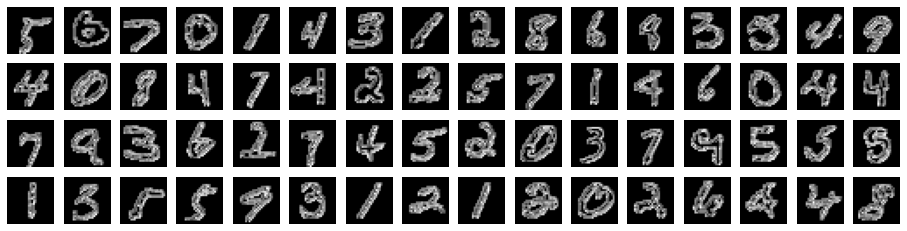

Complex edges Rotation: 	inner_dim = 7 	edge_n = 1


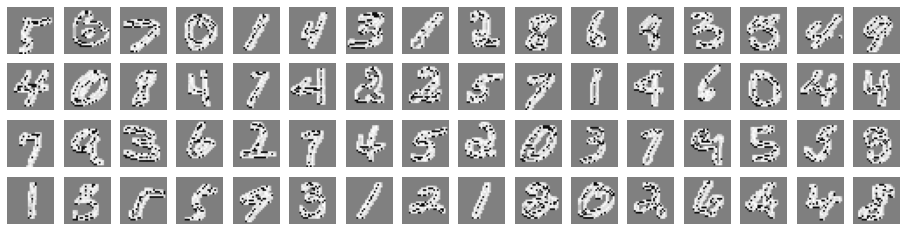

Magnitude: B*C of Factorization (BC=I) 	inner_dim = 7 	edge_n = 1


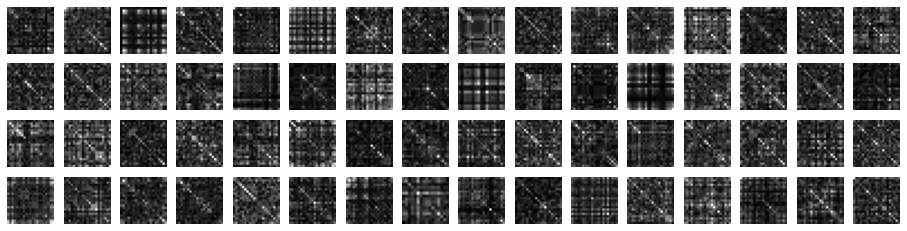

Rotation: B*C of Factorization (BC=I) 	inner_dim = 7 	edge_n = 1


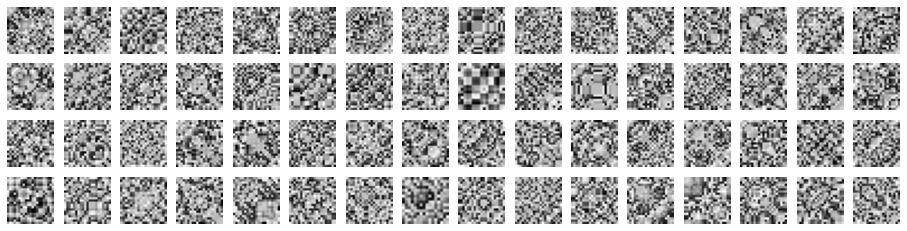

truth table:
 [[5. 6. 7. 0. 1. 4. 3. 1. 2. 8. 6. 8. 3. 5. 4. 9.]
 [4. 0. 8. 4. 7. 4. 2. 2. 5. 7. 1. 4. 6. 0. 4. 4.]
 [7. 9. 3. 6. 2. 7. 4. 5. 2. 0. 3. 7. 9. 5. 5. 5.]
 [1. 3. 5. 5. 9. 3. 1. 2. 1. 2. 0. 2. 6. 4. 4. 8.]]

			2.60 seconds


Complex edges Magnitude: 	inner_dim = 4 	edge_n = 2


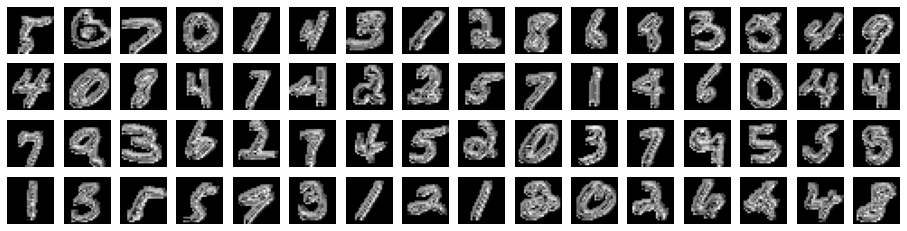

Complex edges Rotation: 	inner_dim = 4 	edge_n = 2


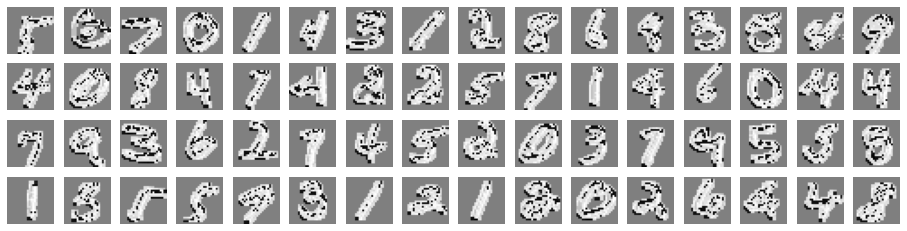

Magnitude: B*C of Factorization (BC=I) 	inner_dim = 4 	edge_n = 2


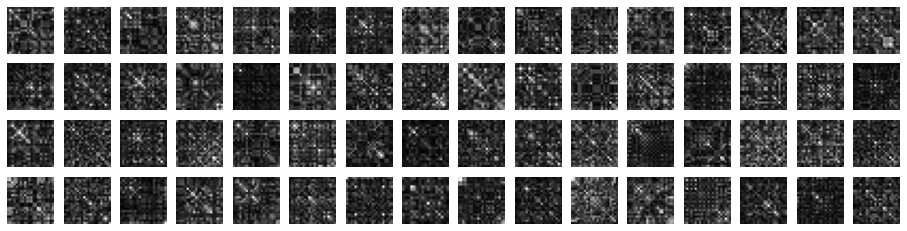

Rotation: B*C of Factorization (BC=I) 	inner_dim = 4 	edge_n = 2


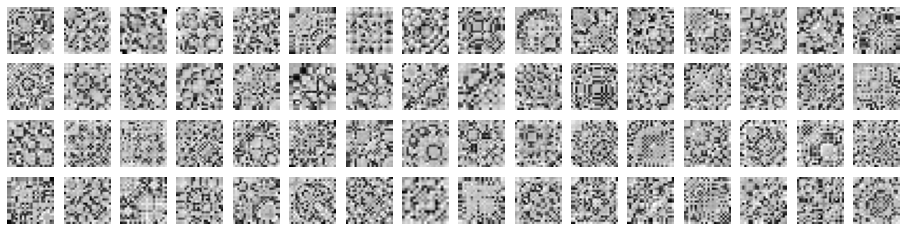

truth table:
 [[5. 6. 7. 0. 1. 4. 3. 1. 2. 8. 6. 8. 3. 5. 4. 9.]
 [4. 0. 8. 4. 7. 4. 2. 2. 5. 7. 1. 4. 6. 0. 4. 4.]
 [7. 9. 3. 6. 2. 7. 4. 5. 2. 0. 3. 7. 9. 5. 5. 5.]
 [1. 3. 5. 5. 9. 3. 1. 2. 1. 2. 0. 2. 6. 4. 4. 8.]]

			2.61 seconds


Complex edges Magnitude: 	inner_dim = 5 	edge_n = 2


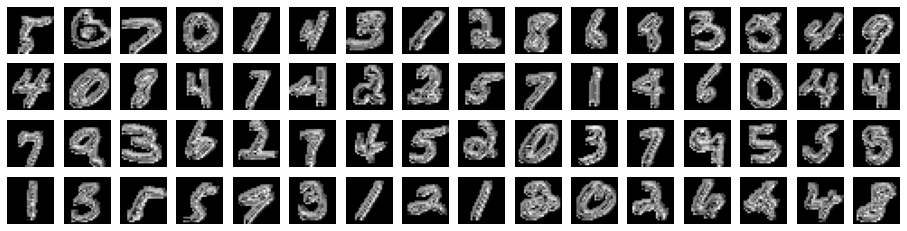

Complex edges Rotation: 	inner_dim = 5 	edge_n = 2


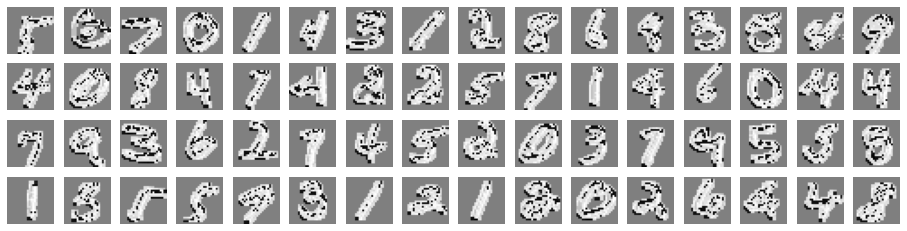

Magnitude: B*C of Factorization (BC=I) 	inner_dim = 5 	edge_n = 2


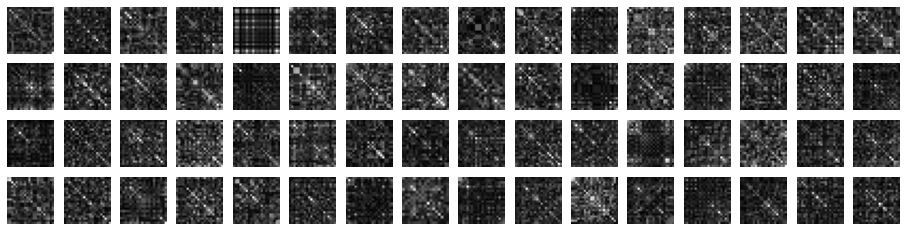

Rotation: B*C of Factorization (BC=I) 	inner_dim = 5 	edge_n = 2


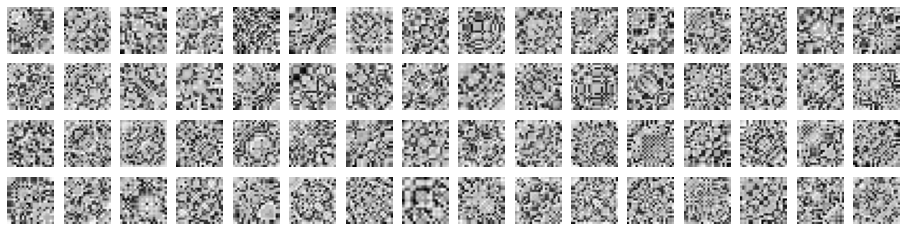

truth table:
 [[5. 6. 7. 0. 1. 4. 3. 1. 2. 8. 6. 8. 3. 5. 4. 9.]
 [4. 0. 8. 4. 7. 4. 2. 2. 5. 7. 1. 4. 6. 0. 4. 4.]
 [7. 9. 3. 6. 2. 7. 4. 5. 2. 0. 3. 7. 9. 5. 5. 5.]
 [1. 3. 5. 5. 9. 3. 1. 2. 1. 2. 0. 2. 6. 4. 4. 8.]]

			2.61 seconds


Complex edges Magnitude: 	inner_dim = 7 	edge_n = 2


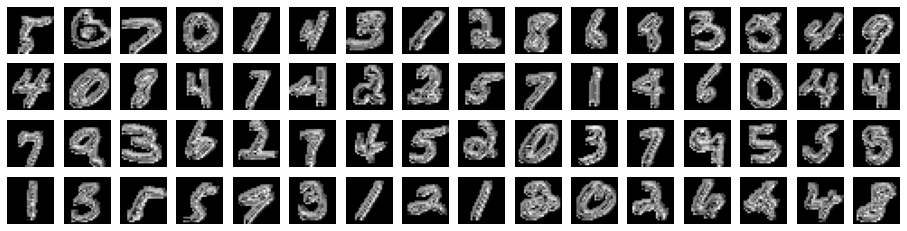

Complex edges Rotation: 	inner_dim = 7 	edge_n = 2


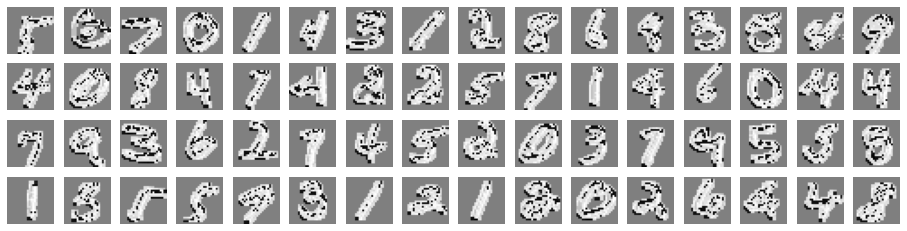

Magnitude: B*C of Factorization (BC=I) 	inner_dim = 7 	edge_n = 2


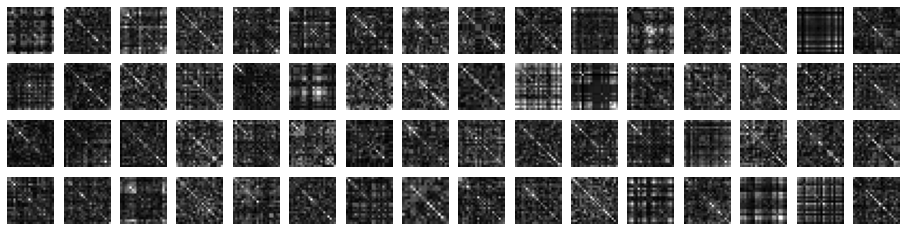

Rotation: B*C of Factorization (BC=I) 	inner_dim = 7 	edge_n = 2


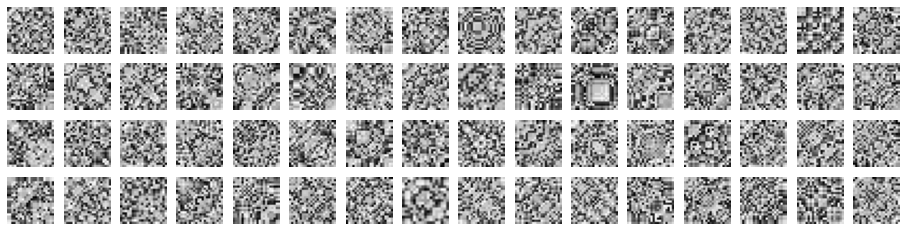

truth table:
 [[5. 6. 7. 0. 1. 4. 3. 1. 2. 8. 6. 8. 3. 5. 4. 9.]
 [4. 0. 8. 4. 7. 4. 2. 2. 5. 7. 1. 4. 6. 0. 4. 4.]
 [7. 9. 3. 6. 2. 7. 4. 5. 2. 0. 3. 7. 9. 5. 5. 5.]
 [1. 3. 5. 5. 9. 3. 1. 2. 1. 2. 0. 2. 6. 4. 4. 8.]]

			2.62 seconds


Complex edges Magnitude: 	inner_dim = 5 	edge_n = 3


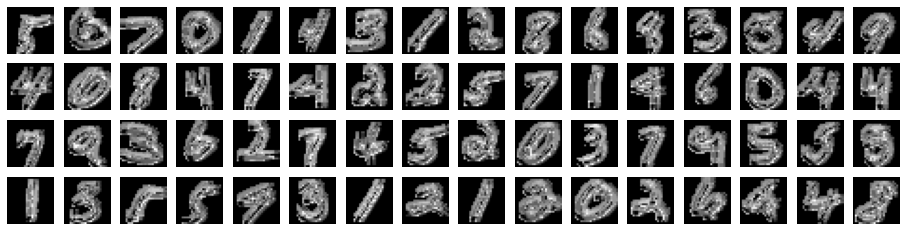

Complex edges Rotation: 	inner_dim = 5 	edge_n = 3


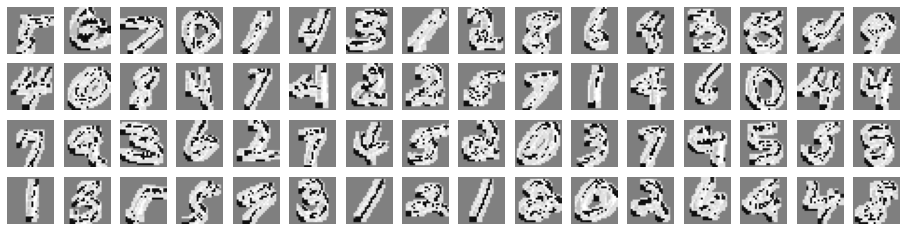

Magnitude: B*C of Factorization (BC=I) 	inner_dim = 5 	edge_n = 3


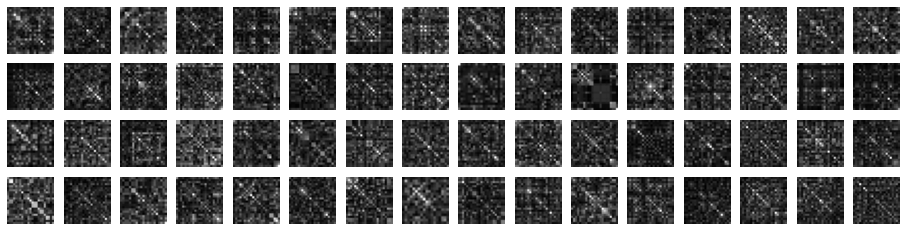

Rotation: B*C of Factorization (BC=I) 	inner_dim = 5 	edge_n = 3


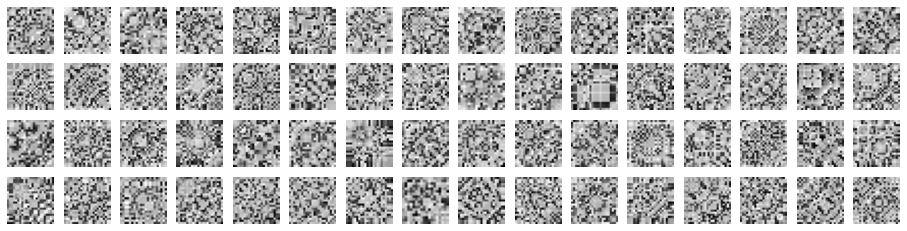

truth table:
 [[5. 6. 7. 0. 1. 4. 3. 1. 2. 8. 6. 8. 3. 5. 4. 9.]
 [4. 0. 8. 4. 7. 4. 2. 2. 5. 7. 1. 4. 6. 0. 4. 4.]
 [7. 9. 3. 6. 2. 7. 4. 5. 2. 0. 3. 7. 9. 5. 5. 5.]
 [1. 3. 5. 5. 9. 3. 1. 2. 1. 2. 0. 2. 6. 4. 4. 8.]]

			2.62 seconds


Complex edges Magnitude: 	inner_dim = 7 	edge_n = 3


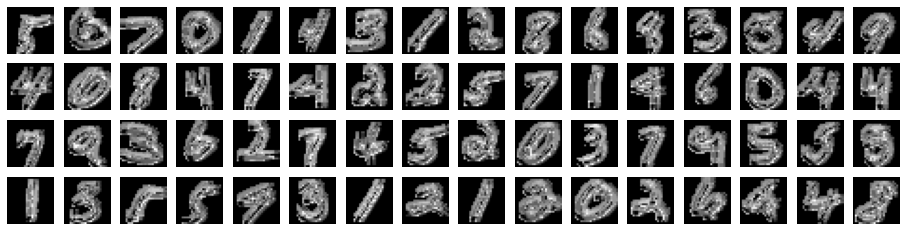

Complex edges Rotation: 	inner_dim = 7 	edge_n = 3


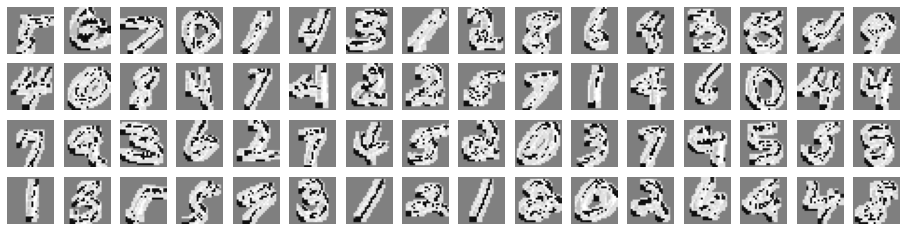

Magnitude: B*C of Factorization (BC=I) 	inner_dim = 7 	edge_n = 3


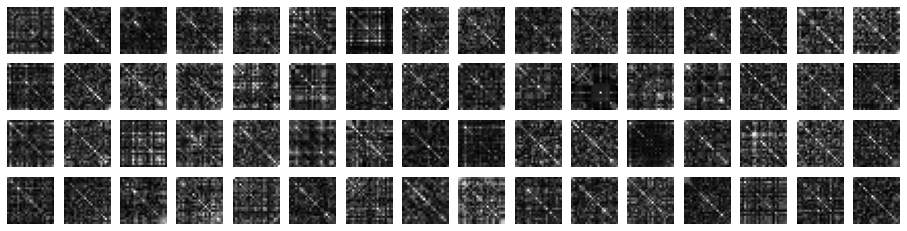

Rotation: B*C of Factorization (BC=I) 	inner_dim = 7 	edge_n = 3


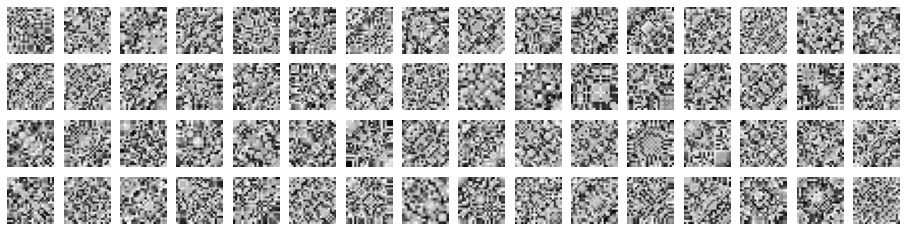

truth table:
 [[5. 6. 7. 0. 1. 4. 3. 1. 2. 8. 6. 8. 3. 5. 4. 9.]
 [4. 0. 8. 4. 7. 4. 2. 2. 5. 7. 1. 4. 6. 0. 4. 4.]
 [7. 9. 3. 6. 2. 7. 4. 5. 2. 0. 3. 7. 9. 5. 5. 5.]
 [1. 3. 5. 5. 9. 3. 1. 2. 1. 2. 0. 2. 6. 4. 4. 8.]]

			2.61 seconds




In [6]:
def show_edge_mat(images, labels, indexes, edge_n, inner_dim, h, w):
    """ Usage:  show_edge_mat(edge_n, inner_dim)
                show random mnist images as 1) complex edges magnitue or rotation, 2) m
    """
    label_mat = np.zeros(h*w)

    #                                 plot random mnist digits edges magnitude
    print('Complex edges Magnitude: \tinner_dim = %i \tedge_n = %i'%(inner_dim, edge_n))
    plt.figure(figsize=(w, h))
    for i in range(len(indexes)):
        plt.subplot(h, w, i + 1)

        image = images[i]

        Z = gray_to_complex_vector_edges(image, edge_n)
        mag_mat, rot_mat = complex_mat_to_int_mat(Z)

        plt.imshow(mag_mat, cmap='gray')

        plt.axis('off')
        label_mat[i] = labels[i]

    #                                 plt.savefig("mnist-samples.png")
    plt.show()
    plt.close('all')

    print('Complex edges Rotation: \tinner_dim = %i \tedge_n = %i'%(inner_dim, edge_n))
    #                                 plot random mnist digits edges rotation
    plt.figure(figsize=(w, h))
    for i in range(len(indexes)):
        plt.subplot(h, w, i + 1)
        image = images[i]

        Z = gray_to_complex_vector_edges(image, edge_n)
        mag_mat, rot_mat = complex_mat_to_int_mat(Z)

        plt.imshow(rot_mat, cmap='gray')

        plt.axis('off')

    plt.show()
    plt.close('all')

    print('Magnitude: B*C of Factorization (BC=I) \tinner_dim = %i \tedge_n = %i'%(inner_dim, edge_n))
    #                                 factorization - magnitude
    plt.figure(figsize=(w, h))
    for i in range(len(indexes)):
        plt.subplot(h, w, i + 1)

        sm_im = images[i]

        outer_dim = sm_im.shape[0]

        B = get_Z_edges_matrix(sm_im, outer_dim, inner_dim, edge_n)

        C = get_encoding_for_basis(B)
        BCI = np.dot(B, C)

        mag_mat, rot_mat = complex_mat_to_int_mat(BCI)
        plt.imshow(mag_mat, cmap='gray')
        plt.axis('off')

    plt.show()
    plt.close('all')

    print('Rotation: B*C of Factorization (BC=I) \tinner_dim = %i \tedge_n = %i'%(inner_dim, edge_n))
    #                                 factorization - matrices
    plt.figure(figsize=(w, h))
    for i in range(len(indexes)):
        plt.subplot(h, w, i + 1)

        sm_im = images[i]

        outer_dim = sm_im.shape[0]

        B = get_Z_edges_matrix(sm_im, outer_dim, inner_dim, edge_n)

        C = get_encoding_for_basis(B)
        BCI = np.dot(B, C)

        mag_mat, rot_mat = complex_mat_to_int_mat(BCI)
        plt.imshow(rot_mat, cmap='gray')
        plt.axis('off')

    plt.show()
    plt.close('all')


    label_mat = label_mat.reshape(h, w)
    print('truth table:\n', label_mat)
    

h = 4
w = 16

indexes = np.random.randint(0, x_train.shape[0], size=h*w)
images = x_train[indexes]
labels = y_train[indexes]

label_mat = np.zeros(h*w)
print('\n\t\tKeras mnist images random selection:')

plt.figure(figsize=(w, h))
for i in range(len(indexes)):
    plt.subplot(h, w, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    label_mat[i] = labels[i]

#                                 plt.savefig("mnist-samples.png")
plt.show()
plt.close('all')

label_mat = label_mat.reshape(h, w)
print('truth table:\n', label_mat)

print('\n\n\t\tComplex edges with varied inner_dim and edge detection width edge_n\n')

edge_n_list = [1, 1, 1, 1, 2, 2, 2, 3, 3]
in_dim_list = [3, 4, 5, 7, 4, 5, 7, 5, 7]

for k in range(len(edge_n_list)):
    edge_n = edge_n_list[k]
    inner_dim = in_dim_list[k]
    start_time = time.time()
    show_edge_mat(images, labels, indexes, edge_n, inner_dim, h, w)
    print('\n\t\t\t%0.2f seconds\n\n'%(time.time() - start_time))

In [7]:
print('Null Hypothesis: This is not a good abstraction of the mnist data set')

run_to_here_time = time.time() - all_cells_start_time
print('\n\t\ttime to this cell: %0.3f \n'%(run_to_here_time))

Null Hypothesis: This is not a good abstraction of the mnist data set

		time to this cell: 26.108 

